In [1]:
%cd /Midgard/home/amirme/an_explanation_model

/Midgard/home/amirme/an_explanation_model


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from functools import partial

from source.project_manager import (
    load_experiment_inconsistency,
    load_experiment_metadata,
    delete_experiment_data,
    check_file_exists,
)
from commands.experiment_6_1 import (
    save_metadata_dir,
    dataset_dir,
    input_shape,
    save_output_dir,
)
os.makedirs(save_output_dir, exist_ok=True)
from source.data_manager import (
    preprocess_masks,
    plot_masks,
    minmax_normalize,
    sum_channels,
    symmetric_minmax_normalize,
    single_query_imagenet,
    save_axis,
)
from source.labels import IMAGENET_LABELS

imshow_args = {"cmap": "jet"}

query_imagenet = partial(
    single_query_imagenet, dataset_dir=dataset_dir, input_shape=input_shape
)

2023-11-04 21:57:48.928484: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-04 21:57:50.710647: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/Midgard/home/amirme/miniconda3/envs/xmodel/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
project_metadata = load_experiment_metadata(save_metadata_dir)
print(project_metadata.columns)
project_metadata = project_metadata.set_index(
    [
        "stream_name",
        "stream_statistic",
        "image_index",
        "baseline_mask_type",
        "alpha_mask_value",
    ]
).sort_index()
print(project_metadata.shape)

Index(['time_to_compute', 'batch_index', 'monitored_statistic_change',
       'path_prefix', 'data_path', 'stream_name', 'stream_statistic',
       'alpha_mask_type', 'alpha_mask_value', 'baseline_mask_type',
       'projection_type', 'projection_distribution', 'projection_top_k',
       'projection_index', 'label', 'architecture', 'method', 'output_layer',
       'dataset', 'image_index', 'input_shape', 'num_classes', 'seed',
       'batch_size', 'max_batches', 'min_change', 'metadata_file_path'],
      dtype='object')
(216, 22)


In [4]:
vc = project_metadata.index.value_counts()
print(vc)
print(len(vc))
image_indices = project_metadata.index.get_level_values("image_index").unique()

stream_name            stream_statistic  image_index  baseline_mask_type  alpha_mask_value
log_probs              meanx             16           gaussian            0.000000            1
vanilla_grad_mask      meanx2            16           gaussian            0.032323            1
results_at_projection  meanx             43           gaussian            0.088889            1
                                                                          0.096970            1
                                                                          0.105051            1
                                                                                             ..
                                         16           gaussian            0.024242            1
                                                                          0.032323            1
                                                                          0.040404            1
                                             

In [5]:
for name in project_metadata.index.names:
    print(name,"=",project_metadata.index.get_level_values(name).value_counts().to_dict())

stream_name = {'log_probs': 72, 'results_at_projection': 72, 'vanilla_grad_mask': 72}
stream_statistic = {'meanx': 144, 'meanx2': 72}
image_index = {16: 54, 17: 54, 20: 54, 43: 54}
baseline_mask_type = {'gaussian': 216}
alpha_mask_value = {0.0: 12, 0.008080808080808: 12, 0.1292929292929293: 12, 0.1212121212121212: 12, 0.1131313131313131: 12, 0.105050505050505: 12, 0.0969696969696969: 12, 0.0888888888888888: 12, 0.0808080808080808: 12, 0.0727272727272727: 12, 0.0646464646464646: 12, 0.0565656565656565: 12, 0.0484848484848484: 12, 0.0404040404040404: 12, 0.0323232323232323: 12, 0.0242424242424242: 12, 0.0161616161616161: 12, 0.1373737373737373: 12}


In [55]:
def spectral_lens_argmax(data):
    image = preprocess_masks(
        data["grad_mask"], preprocesses=[sum_channels]
    )
    image = np.stack(image)
    assert image.ndim == 4, f"{image.shape} must be 4d (T,H,W,C)"
    image = image.argmax(axis=0)
    return image

def spectral_lens_hsi(data):
    image = preprocess_masks(
        data["grad_mask"], preprocesses=[sum_channels, minmax_normalize]
    )
    image = np.stack(image)
    assert image.ndim == 4, f"{image.shape} must be 4d (T,H,W,1)"
    # itensity is the integral of images over T
    I = image.sum(axis=0)
    # normalize image to sum to 1
    # image = image / I
    # assert np.allclose(image.sum(axis=0), 1), f"{image.sum(axis=0)} must be 1"
    # saturation is the entropy of images over T
    # S = -(image * np.log(image)).sum(axis=0)
    # saturation is the variance of images over T
    # S = image.var(axis=0)

    return image[5]

In [56]:
image_indices = [43]
explanations_temp = project_metadata.loc[("vanilla_grad_mask", "meanx2", image_indices, "gaussian",slice(None)), "data_path"]
explanations_temp = explanations_temp.droplevel(["stream_name","stream_statistic","baseline_mask_type"])
explanations_temp = explanations_temp.apply(np.load)
explanations_temp.name = "grad_mask"
explanations_temp.sort_index(inplace=True)
explanations_temp = explanations_temp.reset_index()
explanations_temp = explanations_temp.groupby("image_index",as_index=False).apply(lambda x:spectral_lens_hsi(x))

In [57]:
# original_image, label, image_path = query_imagenet(image_index=43)


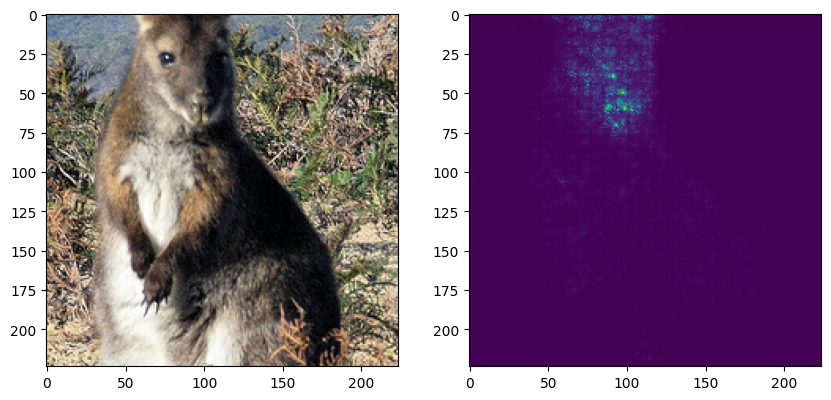

In [58]:
fig,axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(np.squeeze(original_image))
axes[1].imshow(explanations_temp[0])


2023-11-03 08:57:26.995041: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-11-03 08:57:26.995091: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: gondor
2023-11-03 08:57:26.995103: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: gondor
2023-11-03 08:57:26.995205: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.89.2
2023-11-03 08:57:26.995244: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 525.89.2
2023-11-03 08:57:26.995251: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 525.89.2
2023-11-03 08:57:27.183634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (

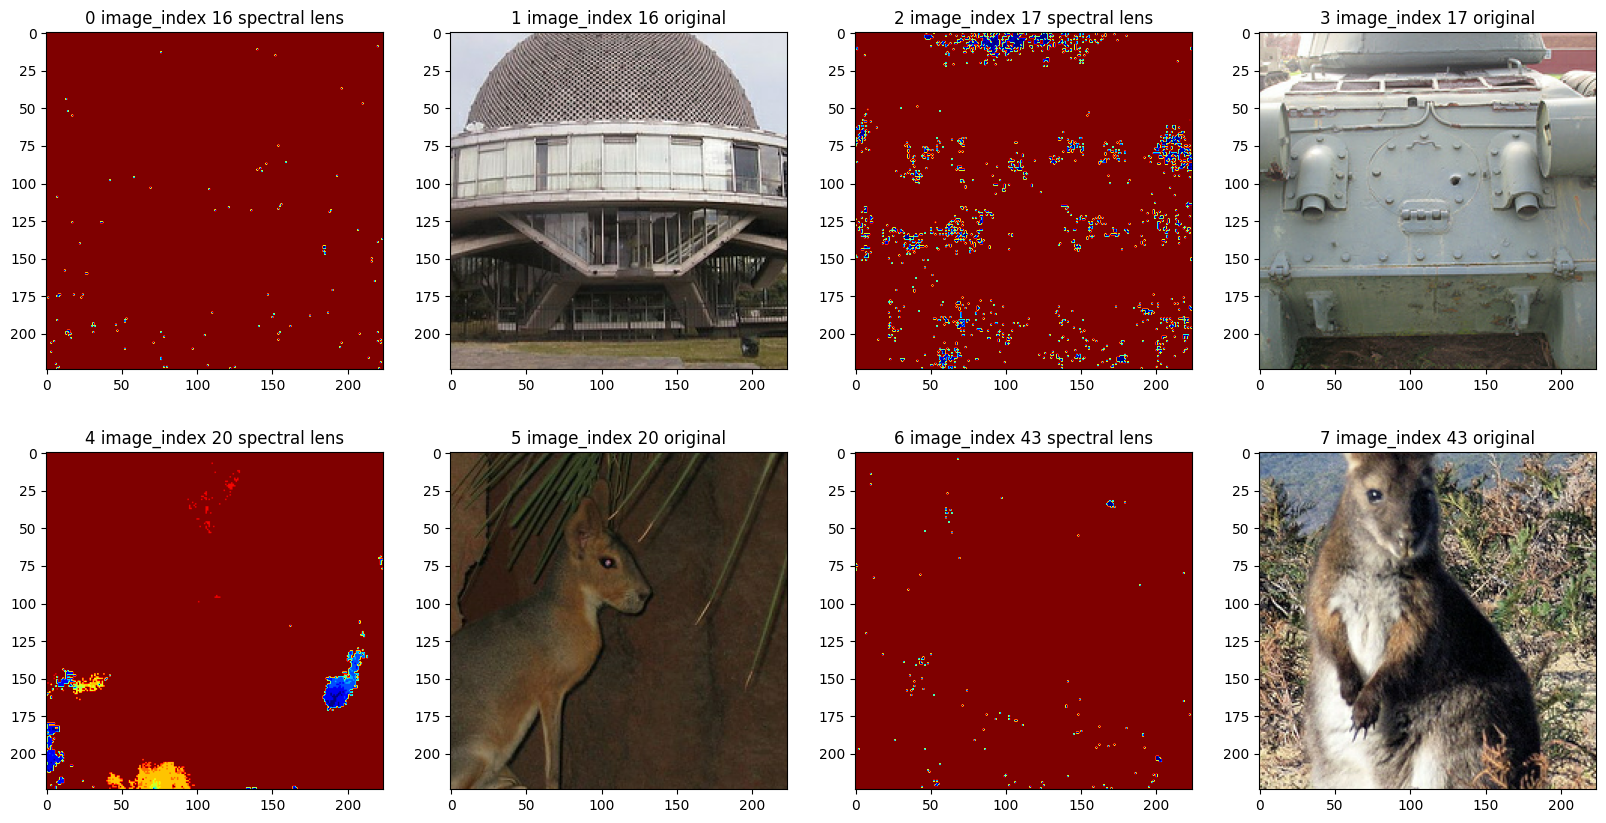

In [8]:
n_cols = 4
n_rows = np.ceil(2 * len(image_indices) // n_cols).astype(int)
fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(5 * n_cols, 5 * n_rows),
)
axes = axes.flatten()
i = 0
for image_index, explanation in zip(image_indices, explanations_temp):
    if i >= axes.size:
        break
    original_image, label, image_path = query_imagenet(image_index=image_index)

    axes[i].imshow(explanation, **imshow_args)
    axes[i].set_title(f"{i} image_index {image_index} spectral lens")
    axes[i + 1].imshow(original_image.squeeze())
    axes[i + 1].set_title(f"{i+1} image_index {image_index} original")
    i += 2
    
plt.show()